# Quantised SqueezeNet

### Imports

In [1]:
import math
import builtins
import numpy as np
import torch
import torch.nn as nn
import torch.jit as jit
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

# Workaround for "RuntimeError: Set changed size during iteration"?
import tqdm
tqdm.monitor_interval = 0

import itertools
from copy import deepcopy
from inspect import getfullargspec
import pandas as pd
from functools import partial

# Remember to:
!export PYTHONPATH=$(readlink -m ./pytorch-playground):$PYTHONPATH
from utee import misc, quant, selector
from imagenet import squeezenet
from collections import OrderedDict

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


### Setup GPU and load the original model
Make sure the ImageNet data is downloaded and converted as detailed [here](./README.md/#imagenet-dataset)

In [2]:
gpu = misc.auto_select_gpu(utility_bound=0, num_gpu=1, selected_gpus='0')
ngpu = len(gpu)
input_size = 224

batch_size = 100
data_root='/tmp/public_dataset/pytorch/'

assert torch.cuda.is_available(), 'no cuda'
torch.manual_seed(117)
torch.cuda.manual_seed(117)

# load model and dataset fetcher
model_orig, ds_fetcher, is_imagenet = selector.select('squeezenet_v1', model_root='~/.torch/models')
model_orig = model_orig.train(False)

tqdmnb = tqdm.tqdm_notebook

Setting GPU: ['0']
Building and initializing squeezenet_v1 parameters


### Evaluate the original model with float32

In [3]:
# Eval model (this is the accuracy at fp32)
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1, acc5 = misc.eval_model(model_orig, val_ds, ngpu=ngpu, is_imagenet=is_imagenet, tqdm_fn=tqdmnb)
print(f'Original model accuracy: ({acc1}, {acc5})')

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9118 s)


HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Original model accuracy: (0.55948, 0.7913)


### Evaluate the original model with float16

In [4]:
model_half = deepcopy(model_orig).half()
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1h, acc5h = misc.eval_model(model_half, val_ds, ngpu=ngpu, is_imagenet=is_imagenet,tqdm_fn=tqdmnb,
                               data_fn=(lambda x: x.half()))
print(f'Test accuracy of ({acc1h},{acc5h}), a drop of ({acc1-acc1h},{acc5-acc5h}) for float16')

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9247 s)


HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




Test accuracy of (0.55962,0.79128), a drop of (-0.000140000000000029,2.0000000000020002e-05) for float16


## Infrastructure for changing models

In [5]:
def model_apply(model, fn, clone=True):
    """
    Recursively map a Module.
    """
    def _apply(m, path):
        if len(getfullargspec(fn).args) > 1:
            um = fn(m, path or '/')
        else:
            um = fn(m)
            
        if um is not None:
            return um
        else:
            for (k, v) in list(m._modules.items()):
                m._modules[k] = _apply(v, f'{path}/{k}')
            return m
    return _apply(deepcopy(model) if clone else model, '')

### Split convolutions into conv+add, and TODO fold batchnorm

In [6]:
class AddBias(nn.Module):
    def __init__(self, num_features):
        super(AddBias, self).__init__()
        self.num_features = num_features
        self.bias = nn.Parameter(torch.Tensor(num_features))
        
    def forward(self, x):
        return x + self.bias.view([1, self.num_features, 1, 1])
    
def split_conv(m):
    if isinstance(m, nn.Conv2d):
        conv = nn.Conv2d(m.in_channels, m.out_channels, m.kernel_size,
                         stride=m.stride, padding=m.padding,
                         dilation=m.dilation, groups=m.groups, bias=False)
        conv.weight = m.weight
        addbias = AddBias(m.out_channels)
        addbias.bias = m.bias
        return nn.Sequential(OrderedDict([('conv', conv), ('addbias', addbias)]))
model_raw = model_apply(model_orig, split_conv)
print(f'Conv2d split into Conv2d + AddBias')

Conv2d split into Conv2d + AddBias


# Collect activation statistics

### Function for inserting loggers

In [7]:
# TODO is this better done with register_forward_hook?
class Logger(nn.Module):
    def __init__(self, name):
        super(Logger, self).__init__()
        #print(f'Creating logger for "{name}"')
        self.name = name
        self.log_items = np.zeros((0, 2))
        
    def forward(self, x):
        # (~4.9it/s)
        # NOTE this takes the min/max of the entire batch (100 images) 
        log_item = [ torch.min(x).data.cpu().numpy()[0],
                     torch.max(x).data.cpu().numpy()[0] ]
        self.log_items = np.append(self.log_items, log_item)                
        return x
    
def duplicate_model_with_logging(model):
    loggers = {}
    def insert_logger(m, path):
        if isinstance(m, (nn.Conv2d, AddBias, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)):
            log_in  = Logger(f'{path}/log_in')
            log_out = Logger(f'{path}/log_out')
            loggers[log_in.name]  = log_in
            loggers[log_out.name] = log_out
            return nn.Sequential(log_in, m, log_out)
    loggers['input'] = Logger('input')
    r = nn.Sequential(loggers['input'],
                      model_apply(model, insert_logger))
    return r, loggers

### Create copy of model with logging, and collect stats over the test set

In [8]:
# Insert loggers
model_log, loggers = duplicate_model_with_logging(model_raw)
# Run over the test set to collect stats
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
# Only collect stats from part of the dataset
n_batch = int(val_ds.n_batch * 0.01)
print(f'Only using {val_ds.n_batch} for stats-collection')

# Collect stats
acc1s, acc5s = misc.eval_model(model_log, val_ds, ngpu=ngpu, is_imagenet=is_imagenet,tqdm_fn=tqdmnb,
                               n_sample=n_batch)
print(f'Test accuracy of ({acc1s},{acc5s}), a drop of ({acc1-acc1s},{acc5-acc5s})')
if (acc1 - acc1s) != 0 or (acc5 - acc5s) != 0:
    print("ERROR: transforms have changed accuracy")

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9202 s)


Only using 500 for stats-collection


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Test accuracy of (0.562,0.794), a drop of (-0.0025200000000000777,-0.0027000000000000357)
ERROR: transforms have changed accuracy


### Get scale factors from the collected stats

In [9]:
# We now have statistics for all the activations. Reduce to a scale factor for each one.
def scale_factor_from_range(min, max, max_q_level=(2**7-1), pow2=False):
    pos_range = builtins.max(abs(min), abs(max))
    
    if pow2:
        # lock to powers of 2
        pos_range = 2.0**(math.ceil(math.log2(pos_range+1e-12)))
    
    # val = q_val * scale_factor; so:
    scale_factor = pos_range / max_q_level
    return float(scale_factor)
ranges = { k : ( np.min(items[0]), np.max(items[1]) )
           for (k,v) in loggers.items()
           for items in [np.asarray(v.log_items)] }
def max_q_level(bitwidth):
    if bitwidth is None:
        bitwidth = 8
    return 2.0 ** (bitwidth - 1)#TEMP# - 1
def scale_factors_for(bitwidth=8.0, pow2=False):
    max_q = max_q_level(bitwidth)
    return { k : scale_factor_from_range(v[0], v[1], max_q, pow2)
             for (k,v) in ranges.items() }
ranges_df = pd.DataFrame()
ranges_df['Location'] = ranges.keys()
ranges_df['Min'], ranges_df['Max'] = zip(*ranges.values())
ranges_df

,Location,Min,Max
0,input,-2.117904,2.640000
1,/features/0/conv/log_in,-2.117904,2.640000
2,/features/0/conv/log_out,-18.191307,18.393581
3,/features/0/addbias/log_in,-18.191307,18.393581
4,/features/0/addbias/log_out,-17.927345,18.657543
5,/features/3/group1/squeeze/conv/log_in,0.000000,18.657543
6,/features/3/group1/squeeze/conv/log_out,-49.645222,41.118736
7,/features/3/group1/squeeze/addbias/log_in,-49.645222,41.118736
8,/features/3/group1/squeeze/addbias/log_out,-48.723850,40.367935
9,/features/3/group2/expand1x1/conv/log_in,0.000000,40.367935


### Visualise scale factors

<IPython.core.display.Javascript object>


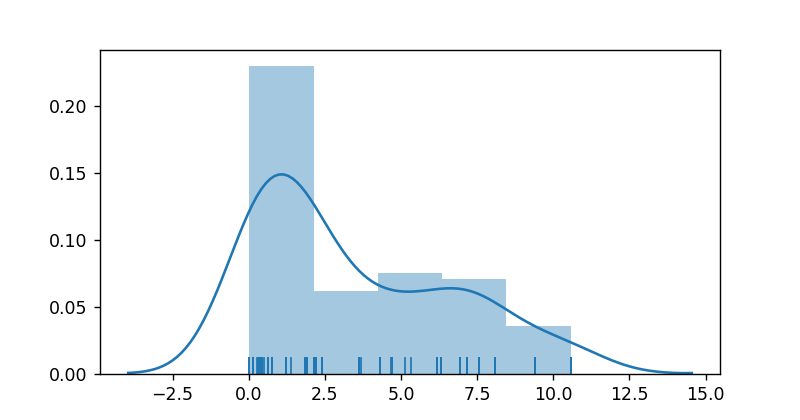

In [37]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sbs
sbs.distplot(list(scale_factors_for().values()), hist=True, rug=True)

#np.percentile(data, q=[0, 1, 5, 95, 99, 100], axis=0)

# Modifying for quantised inference

### Functions to quantise a model

In [11]:
model_orig

SqueezeNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Fire(
      (group1): Sequential(
        (squeeze): Conv2d (64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
      )
      (group2): Sequential(
        (expand1x1): Conv2d (16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
      )
      (group3): Sequential(
        (expand3x3): Conv2d (16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace)
      )
    )
    (4): Fire(
      (group1): Sequential(
        (squeeze): Conv2d (128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
      )
      (group2): Sequential(
        (expand1x1): Conv2d (16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
  

In [12]:
def quantise(x, scale_factor, bitwidth=None):
    # Quantise the activation
    x = x.div(scale_factor)
    x = x.round()
    #x = x.int()
    
    # Optionally saturate into fixed bit-width
    if bitwidth is not None:
        max_q = max_q_level(bitwidth)
        x = x.clamp(-max_q, max_q)
        
    x = x.mul(scale_factor)
    
    return x

def quantise_const(x, scale_factor, bitwidth, pow2=False):
    if scale_factor is None:
        # If no scale-factor is given, decide on one from the data
        min = x.min().data.cpu().numpy()[0]
        max = x.max().data.cpu().numpy()[0]
        scale_factor = scale_factor_from_range(min, max, max_q_level(bitwidth), pow2)
        
    qdata = quantise(x.data, scale_factor, bitwidth)
    return qdata, scale_factor

def dequantise(x, scale_factor):
    #x = x.float()
    # Quantising scales back up, so dequantising is identity
    #x = x.mul(scale_factor)
    return x

class Quantise(nn.Module):
    def __init__(self, scale_factor, bitwidth=None):
        super(Quantise, self).__init__()
        self.scale_factor = scale_factor
        self.bitwidth = bitwidth
        
    def forward(self, x):
        x = quantise(x, self.scale_factor, self.bitwidth)
        return x

class Saturate(nn.Module):
    def __init__(self, bitwidth):
        super(Saturate, self).__init__()
        self.bitwidth = bitwidth
        self.saturate_at = max_q_level(bitwidth)
        
    def forward(self, x):
        x = x.clamp(-self.saturate_at, self.saturate_at)
        return x

class Dequantise(nn.Module):
    def __init__(self, scale_factor):
        super(Dequantise, self).__init__()
        self.scale_factor = scale_factor
        
    def forward(self, x):
        x = dequantise(x, self.scale_factor)
        return x
    
# This just locks values to quantization levels after these ops.
# Also need to:
#  - Quantise weights + biases
#  - Merge Conv2d and BatchNorm weights before quantising (no BatchNorm in this SqN)
#  - Requantize after convolutions to lower bitwidth
#  - 
def duplicate_model_with_quantisation(model, bw_activation=8.0, bw_weight=8.0, bw_bias=None,
                                      constrain_bias_sf=True, pow2_sf=False):
    scale_factors = scale_factors_for(bitwidth=bw_activation, pow2=pow2_sf)
    def insert_quantise(m, path):
        # (nn.Conv2d, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)
        if isinstance(m, (nn.Conv2d)):
            sf_conv_in     = scale_factors[f'{path}/conv/log_in']
            sf_conv_out    = scale_factors[f'{path}/conv/log_out']
            sf_addbias_in  = scale_factors[f'{path}/addbias/log_in']
            sf_addbias_out = scale_factors[f'{path}/addbias/log_out']
            
            # Quantise Conv2d weights to [8] bits
            m.weight.data, sf_weight = quantise_const(m.weight, scale_factor=None, bitwidth=bw_weight, pow2=pow2_sf)
            
            # Bit-width after conv
            bw_conv_out = (bw_activation + bw_weight + 
                           int(math.ceil(math.log2(m.kernel_size[0] *
                                                   m.kernel_size[1] * 
                                                   m.in_channels))))
            
            # Quantise Conv2d biases to the same sf as the activation
            if constrain_bias_sf:
                sf_bias = sf_conv_in * sf_weight
            else:
                sf_bias = None
            
            if m.bias is not None:
                m.bias.data, _ = quantise_const(m.bias, scale_factor=sf_bias, bitwidth=bw_bias, pow2=pow2_sf)
            
            return nn.Sequential(# Quantise input to 8 bits
                                 Quantise(sf_conv_in, bw_activation),
                                 # Perform conv + bias
                                 m,
                                 # Saturate to emulate fixed bit-width
                                 Saturate(bitwidth=bw_conv_out),
                                 # Dequantise
                                 Dequantise(sf_bias))
#             return nn.Sequential(m,
#                                  Quantise(sf_addbias_out, bw_activation))
        elif isinstance(m, (AddBias)):
            print("ERROR: please use split convs for logging, and original model for quantizing")
            exit(1)
        elif isinstance(m, (nn.AvgPool2d)):
            sf_out = scale_factors[f'{path}/log_out']
            return nn.Sequential(m,
                                 Quantise(sf_out, bw_activation))
            
    return model_apply(model, insert_quantise)

### Quantise the model and evaluate the drop in accuracy

In [ ]:
# Quantise model
model_quant = duplicate_model_with_quantisation(model_orig)
# Evaluate accuracy
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1q, acc5q = misc.eval_model(model_quant, val_ds, ngpu=ngpu, is_imagenet=is_imagenet, tqdm_fn=tqdmnb)
print(f'Test accuracy of ({acc1q},{acc5q}), a drop of ({acc1-acc1q},{acc5-acc5q})')

# DEFAULT: bw_activation=8.0, bw_weight=8.0, bw_bias=None, constrain_bias_sf=True, pow2_sf=False

# <default>               : Test accuracy of (0.5674,0.7882), a drop of (-0.007920000000000038,0.0030999999999999917)
# constrain_bias_sf=False : Test accuracy of (0.5653,0.7885), a drop of (-0.005820000000000047,0.0028000000000000247)
# cbs=False, pow2_sf=True : Test accuracy of (0.5534,0.7779), a drop of (0.006079999999999974,0.013399999999999967)
                     #all : Test accuracy of (0.53832,0.77446), a drop of (0.021159999999999957,0.016839999999999966)
# cbs=F, p2sf=T, bw_b=8   : -
                     #all : Test accuracy of (0.53832,0.77446), a drop of (0.021159999999999957,0.016839999999999966)
# " using addbias range   : -
                     #all : Test accuracy of (0.53832,0.77446), a drop of (0.021159999999999957,0.016839999999999966)
# " quantise before  #all : Test accuracy of (0.53828,0.7743), a drop of (0.021199999999999997,0.017000000000000015)
# defaults, q before #all : 

### Sweep over bit-width to generate chart

In [15]:
# FIXME Use the same dataset fetcher (it should loop if we use all the batches each time)
bitwidths = [ v * 0.1 for v in range(100, 50, -5) ]
nonpow2 = [ misc.eval_model(model, val_ds, ngpu=ngpu, is_imagenet=is_imagenet,
                            tqdm_fn=partial(tqdmnb, leave=False, desc='Batches'))
            for bw in tqdm.tqdm_notebook(bitwidths, desc='Bit-widths (non-pow2)')
            for val_ds in [ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)]
            for model in [duplicate_model_with_quantisation(model_orig,
                                                            bw_activation=bw,
                                                            bw_weight=bw,
                                                            bw_bias=None,
                                                            constrain_bias_sf=True,
                                                            pow2_sf=False)]
          ]
pow2    = [ misc.eval_model(model, val_ds, ngpu=ngpu, is_imagenet=is_imagenet,
                            tqdm_fn=partial(tqdmnb, leave=False, desc='Batches'))
            for bw in tqdm.tqdm_notebook(bitwidths, desc='Bit-widths (pow2)')
            for val_ds in [ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)]
            for model in [duplicate_model_with_quantisation(model_orig,
                                                            bw_activation=bw,
                                                            bw_weight=bw,
                                                            bw_bias=None,
                                                            constrain_bias_sf=True,
                                                            pow2_sf=True)]
          ]

HBox(children=(IntProgress(value=0, description='Bit-widths (non-pow2)', max=10), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9332 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

=> Done (5.8902 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9081 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9227 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9371 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.8957 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9204 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9541 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (6.0608 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9067 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Bit-widths (pow2)', max=10), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9166 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9605 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9314 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9405 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9209 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9046 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9164 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.8939 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9238 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.8988 s)


HBox(children=(IntProgress(value=0, description='Batches', max=500), HTML(value='')))

In [18]:
### Save results to file, since they take a while to compute...
list(zip(bitwidths, nonpow2, pow2))

[(10.0, (0.55916, 0.79204), (0.55842, 0.79018)),
 (9.5, (0.55898, 0.79104), (0.55894, 0.78958)),
 (9.0, (0.55574, 0.78846), (0.55862, 0.79012)),
 (8.5, (0.55734, 0.78924), (0.5516, 0.78372)),
 (8.0, (0.55572, 0.78852), (0.53822, 0.77438)),
 (7.5, (0.54132, 0.776), (0.50618, 0.74292)),
 (7.0, (0.5234, 0.75822), (0.42706, 0.66786)),
 (6.5, (0.48398, 0.72486), (0.35786, 0.59128)),
 (6.0, (0.35858, 0.59538), (0.14844, 0.30202)),
 (5.5, (0.2098, 0.40778), (0.04672, 0.11718))]

In [25]:
bw_df = pd.DataFrame(index=bitwidths)
bw_df.rename_axis("Bitwidth")
bw_df['Top-1 accuracy'], bw_df['Top-5 accuracy'] = zip(*nonpow2)
bw_df['Top-1 accuracy (pow2)'], bw_df['Top-5 accuracy (pow2)'] = zip(*pow2)

bw_df

,Top-1 accuracy,Top-5 accuracy,Top-1 accuracy (pow2),Top-5 accuracy (pow2)
10.0,0.55916,0.79204,0.55842,0.79018
9.5,0.55898,0.79104,0.55894,0.78958
9.0,0.55574,0.78846,0.55862,0.79012
8.5,0.55734,0.78924,0.55160,0.78372
8.0,0.55572,0.78852,0.53822,0.77438
7.5,0.54132,0.77600,0.50618,0.74292
7.0,0.52340,0.75822,0.42706,0.66786
6.5,0.48398,0.72486,0.35786,0.59128
6.0,0.35858,0.59538,0.14844,0.30202
5.5,0.20980,0.40778,0.04672,0.11718


<IPython.core.display.Javascript object>


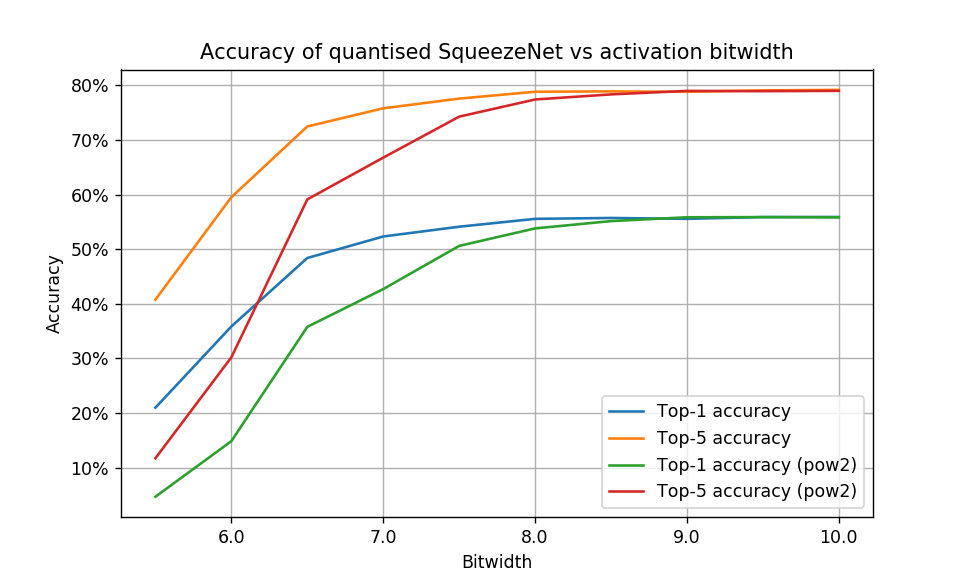

In [47]:
fig, ax = plt.subplots()
bw_df.plot(ax=ax)
ax.grid(True)
#ax.legend(loc='right')
ax.set_title('Accuracy of quantised SqueezeNet vs activation bitwidth')
ax.set_xlabel('Bitwidth')
ax.xaxis.set_major_formatter(mtick.FuncFormatter('{:.1f}'.format))
ax.set_ylabel('Accuracy')
ax.yaxis.set_major_formatter(mtick.FuncFormatter('{:.0%}'.format))
plt.show()

### Experiment with the pow2-scale-factor linear quantisation scheme from the playground

In [60]:
def linear_quantize(input, sf, bits):
    assert bits >= 1, bits
    if bits == 1:
        return torch.sign(input) - 1
    delta = math.pow(2.0, -sf)
    bound = math.pow(2.0, bits-1)
    min_val = - bound
    max_val = bound - 1
    
    x = input.div(delta)
    x.round_()
    if isinstance(x, Variable):
        x.data.clamp_(min_val, max_val)
    else:
        x.clamp_(min_val, max_val)
    x.mul_(delta)
    return x

class LinearQuant(nn.Module):
    def __init__(self, sf, bits):
        super(LinearQuant, self).__init__()
        self.bits = bits
        self.sf = sf

    def forward(self, input):
        output = linear_quantize(input, self.sf, self.bits)
        return output

    def __repr__(self):
        return '{}(sf={}, bits={})'.format(
            self.__class__.__name__, self.sf, self.bits)

def duplicate_model_with_q(model):
    def convert_sf(sf, pow2=True):
        l = math.log2( sf * (2**7-1) / (2**7) )
        if pow2:
            return -math.ceil(l)
        else:
            return -l
    def insert_quantise(m, path):
        pow2bias       = False
        pow2weight     = False
        pow2activation = True
        bw_bias        = 32
        
        # (nn.Conv2d, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)
        if isinstance(m, (nn.Conv2d)):
            sf_conv_in  = scale_factors[f'{path}/conv/log_in']
            sf_conv_out  = scale_factors[f'{path}/conv/log_out']
            sf_bias_in = scale_factors[f'{path}/addbias/log_in']
            
            # Quantise Conv2d weights to 8 bits
            bw_conv_in = 8
            sf_weight = quantise_const(deepcopy(m.weight), scale_factor=None, max_q_level=2**(bw_conv_in-1))
            sf_weight = convert_sf(sf_weight, pow2=pow2weight)
            m.weight.data = linear_quantize(m.weight.data, sf_weight, bits=bw_conv_in)
            
            # Bit-width after conv
            bw_conv_out = (2*bw_conv_in + 
                           int(math.ceil(math.log2(m.kernel_size[0] *
                                                   m.kernel_size[1] * 
                                                   m.in_channels))))
            
            sf_bias = quantise_const(deepcopy(m.bias), scale_factor=None, max_q_level=2**(bw_bias-1))
            sf_bias = convert_sf(sf_bias, pow2=pow2bias)
            m.bias.data = linear_quantize(m.bias.data, sf_bias, bits=bw_bias)
            
            sf_2 = convert_sf(scale_factors[f'{path}/conv/log_out'], pow2=pow2activation)
            return nn.Sequential(m,
                                 LinearQuant(sf=sf_2, bits=8))
        elif isinstance(m, (AddBias)):
            print("ERROR: please use split convs for logging, and original model for quantizing")
            exit(1)
        elif isinstance(m, (nn.AvgPool2d)):
            sf_2 = convert_sf(scale_factors[f'{path}/log_out'], pow2=pow2activation)
            return nn.Sequential(m,
                                 LinearQuant(sf=sf_2, bits=8))
        
    return nn.Sequential(model_apply(model, insert_quantise))

In [91]:
# Quantise model
model_quant = duplicate_model_with_q(model_orig)
# Evaluate accuracy
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1q2, acc5q2 = misc.eval_model(model_quant, val_ds, ngpu=ngpu, is_imagenet=is_imagenet)#, n_sample=100)
print(f'Test accuracy of ({acc1q2},{acc5q2}), a drop of ({acc1-acc1q2},{acc5-acc5q2})')
#   bias    | non-pow2 sf |    Test Accuracy   |      Drop
# bit-width |  b  w  a    |   top-1    top-5   |   top-1    top-5
#===========+=============+====================+==================
#    8      |  -  -  -    |  0.53834  0.77446  |  0.02114  0.01684
#   32      |  -  -  -    |  0.53882  0.77456  |  0.02066  0.01674
#    8      |  Y  -  -    |  0.53756  0.77416  |  0.02192  0.01714
#   32      |  Y  -  -    |  0.53906  0.77370  |  0.02042  0.01760
#    8      |  -  Y  -    |  0.54574  0.77916  |  0.01374  0.01214
#    8      |  Y  Y  -    |  0.54616  0.77828  |  0.01332  0.01302
#   32      |  Y  Y  -    |  0.54484  0.77956  |  0.01464  0.01174
#    8      |  -  -  Y    |  0.54594  0.78008  |  0.01354  0.01122
#    8      |  Y  Y  Y    |  0.55156  0.78526  |  0.00792  0.00604
#   32      |  Y  Y  Y    |  0.55294  0.78618  |  0.00654  0.00512

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9057 s)


HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Test accuracy of (0.54484,0.77956), a drop of (0.014639999999999986,0.011739999999999973)


---------
# Random code & notes:

In [ ]:
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
(data, target) = next(val_ds)
data = Variable(torch.FloatTensor(data)).cuda()
model_cuda = torch.nn.DataParallel(model_raw.eval(), device_ids=range(ngpu)).cuda()
trace, out = jit.trace(model_cuda, data)

In [ ]:
trace.graph()

In [ ]:
print(trace)

In [ ]:
# We do dumb quantisation; no fine-tuning.

weights_bw    = 8
biases_bw     = 32
activation_bw = 8
overflow_rate = 0.0
n_sample      = 20
quant_method  = "linear"
    
def duplicate_model_with_quant(model, bits, overflow_rate=0.0, counter=10, type='linear'):
    """assume that original model has at least a nn.Sequential"""
    assert type in ['linear', 'minmax', 'log', 'tanh']
    if isinstance(model, nn.Sequential):
        print(f'> Sequential')
        l = OrderedDict()
        for k, v in model._modules.items():
            print(f'Looking at : {k}')
            if isinstance(v, (nn.Conv2d, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)):
                parameters = list(v.parameters())
                if isinstance(v, nn.Conv2d):
                    print(f"Found Conv2D:")
                    print(f"  weights: [o,i,k,k] {parameters[0].shape}")
                    print(f"  biases : [o] {parameters[1].shape}")
                l[k] = v
                
            else:
                l[k] = duplicate_model_with_quant(v, bits, overflow_rate, counter, type)
        m = nn.Sequential(l)
        return m
    else:
        print(f'> Not Sequential')
        for k, v in model._modules.items():
            model._modules[k] = duplicate_model_with_quant(v, bits, overflow_rate, counter, type)
        return model

model_quant = duplicate_model_with_quant(model_raw, bits=activation_bw, overflow_rate=overflow_rate,
                                               counter=n_sample, type=quant_method)

In [ ]:
# eval model
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1q, acc5q = misc.eval_model(model_quant, val_ds, ngpu=ngpu, is_imagenet=is_imagenet)

In [ ]:
acc1q, acc5q

# Exporting model
There is the existing ONNX exporter. Either modify that, or manually add functions to each type of Module and call them recursively.

## MobileNet
Search GitHub; there seem to be plenty of implementations. E.g. https://github.com/marvis/pytorch-mobilenet
There are also implementations for v2.

## MobileNet-SSD
Try modifying https://github.com/amdegroot/ssd.pytorch:
  - Use MobileNet feature extractor
  - Use dw convolutions in SSD (SSDLite)

In [ ]:
model_raw.state_dict().keys()